# Online Fraud Detection Project


# Libraries and Modules Used


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score as ras, classification_report, roc_curve, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

from smtplib import SMTP


# For Label Encoding
from sklearn.preprocessing import LabelEncoder

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# 1. Data Loading


In [2]:
data = pd.read_csv('onlinefraud.csv')
data.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# 2. Data Exploration


In [3]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
data.describe()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [5]:
data.shape

(6362620, 11)

In [6]:

# Check for missing values
missing_values = data.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [7]:
# Check for duplicated rows
duplicates = data.duplicated().sum()
print("Duplicated rows:", duplicates)

Duplicated rows: 0


In [8]:
# Detect columns with identical values
unique_counts = data.nunique()
identical_cols = unique_counts[unique_counts == 1].index.tolist()
print("Columns with identical values:", identical_cols)

Columns with identical values: []


# 3. Data Analysis


In [9]:
data.corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


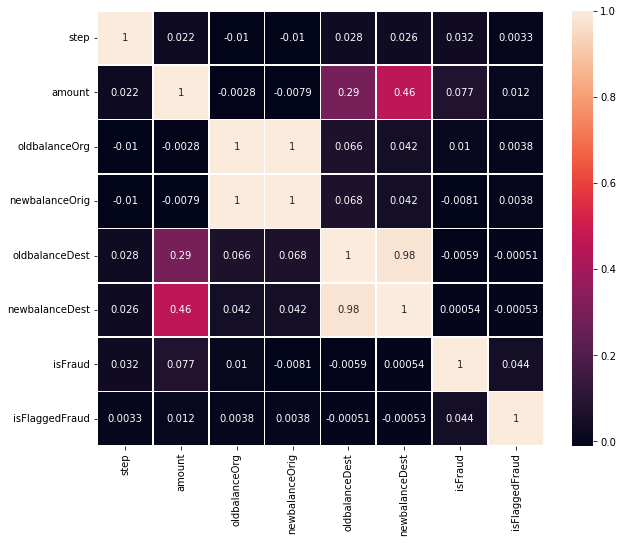

In [10]:
plt.figure(figsize=(10, 8))  
sns.heatmap(data.corr(), lw=0.7, annot=True)
plt.show()


# 4. Data Visualization


In [11]:
# Identify variable types
obj = (data.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:", len(object_cols))

int_ = (data.dtypes == 'int64') 
num_cols = list(int_[int_].index)
print("Integer variables:", len(num_cols))

fl = (data.dtypes == 'float64')
fl_cols = list(fl[fl].index)
print("Float variables:", len(fl_cols))

# Output the column names for verification
print("Categorical columns:", object_cols)
print("Integer columns:", num_cols)
print("Float columns:", fl_cols)


Categorical variables: 3
Integer variables: 3
Float variables: 5
Categorical columns: ['type', 'nameOrig', 'nameDest']
Integer columns: ['step', 'isFraud', 'isFlaggedFraud']
Float columns: ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']


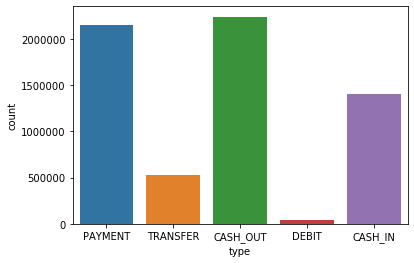

In [12]:
sns.countplot(x='type', data=data)

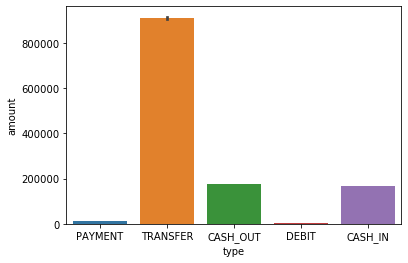

In [13]:
sns.barplot(x='type', y='amount', data=data)

In [14]:
data['isFraud'].value_counts()


0    6354407
1       8213
Name: isFraud, dtype: int64

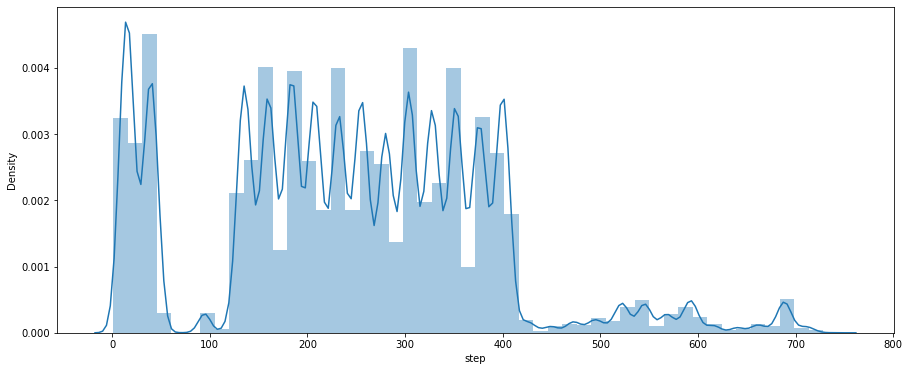

In [15]:
plt.figure(figsize=(15, 6))
sns.distplot(data['step'], bins=50)


# 6. Outlier Detection


In [16]:
# Detect outliers for numerical columns
def detect_outliers_numerical(data, columns):
    outlier_indices = {}
    for col in columns:
        Q1 = np.percentile(data[col], 25)
        Q3 = np.percentile(data[col], 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_indices[col] = data[(data[col] < lower_bound) | (data[col] > upper_bound)].index
    return outlier_indices

# Detect outliers for categorical columns based on frequency
def detect_outliers_categorical(data, columns, threshold=0.01):
    outlier_indices = {}
    for col in columns:
        freq = data[col].value_counts(normalize=True)
        rare_labels = freq[freq < threshold].index
        outlier_indices[col] = data[data[col].isin(rare_labels)].index
    return outlier_indices

outliers_numerical = detect_outliers_numerical(data, fl_cols)
print("Numerical outliers detected:")
for col, indices in outliers_numerical.items():
    print(f"{col}: {len(indices)} outliers")

outliers_categorical = detect_outliers_categorical(data, object_cols)
print("Categorical outliers detected:")
for col, indices in outliers_categorical.items():
    print(f"{col}: {len(indices)} outliers")

Numerical outliers detected:
amount: 338078 outliers
oldbalanceOrg: 1112507 outliers
newbalanceOrig: 1053391 outliers
oldbalanceDest: 786135 outliers
newbalanceDest: 738527 outliers
Categorical outliers detected:
type: 41432 outliers
nameOrig: 6362620 outliers
nameDest: 6362620 outliers


# 6. Feature Engineering



In [17]:
# Encoding categorical variables
type_new = pd.get_dummies(data['type'], drop_first=True)
data_new = pd.concat([data, type_new], axis=1)




In [18]:
# Dropping unnecessary columns
data_new = data_new.drop(['type', 'nameOrig', 'nameDest'], axis=1)


In [19]:
# Imputing missing values
imputer = SimpleImputer(strategy='mean')
data_new = pd.DataFrame(imputer.fit_transform(data_new), columns=data_new.columns)


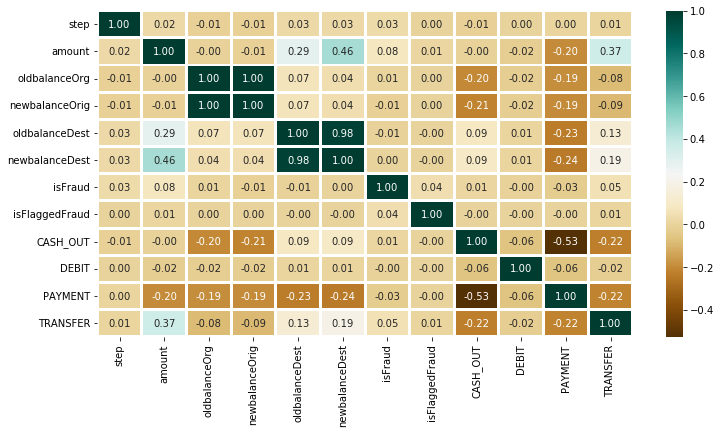

In [20]:
# Correlation heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(data_new.corr(), cmap='BrBG', fmt='.2f', linewidths=2, annot=True)
plt.show()


# 8. Handling Imbalanced Data


In [21]:
X = data_new.drop(['isFraud'], axis=1)
y = data_new['isFraud']

print(X.shape, y.shape)


(6362620, 11) (6362620,)


In [22]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Original dataset shape:", Counter(y))
print("Resampled dataset shape:", Counter(y_resampled))


Original dataset shape: Counter({0.0: 6354407, 1.0: 8213})
Resampled dataset shape: Counter({0.0: 6354407, 1.0: 6354407})


# 9. Data Splitting


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)


In [24]:
data.shape

(6362620, 11)

In [25]:
data.describe()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [26]:
data.corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


# 10. Model Training and Evaluation



Training Logistic Regression...
Logistic Regression : 
Training Accuracy :  0.9656441971559094
Validation Accuracy :  0.9656740574023731



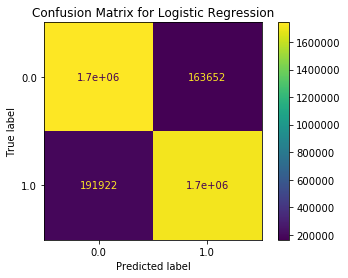

----------------------------------------------------


In [27]:
model = LogisticRegression()
print("Training Logistic Regression...")
model.fit(X_train, y_train)

train_preds = model.predict_proba(X_train)[:, 1]
val_preds = model.predict_proba(X_test)[:, 1]

train_auc = ras(y_train, train_preds)
val_auc = ras(y_test, val_preds)

print('Logistic Regression : ')
print('Training Accuracy : ', train_auc)
print('Validation Accuracy : ', val_auc)
print()

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title('Confusion Matrix for Logistic Regression')
plt.show()
print('----------------------------------------------------')


Training XGBoost...
XGBoost : 
Training Accuracy :  0.9999829884753588
Validation Accuracy :  0.9999803496666435



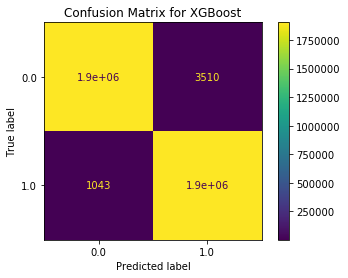

----------------------------------------------------


In [28]:
model = XGBClassifier()
print("Training XGBoost...")
model.fit(X_train, y_train)

train_preds = model.predict_proba(X_train)[:, 1]
val_preds = model.predict_proba(X_test)[:, 1]

train_auc = ras(y_train, train_preds)
val_auc = ras(y_test, val_preds)

print('XGBoost : ')
print('Training Accuracy : ', train_auc)
print('Validation Accuracy : ', val_auc)
print()

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title('Confusion Matrix for XGBoost')
plt.show()
print('----------------------------------------------------')


Training Random Forest...
Random Forest : 
Training Accuracy :  0.9999998850068438
Validation Accuracy :  0.9999469018086247



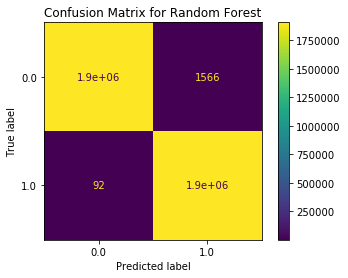

----------------------------------------------------


In [29]:

model3 = RandomForestClassifier(n_estimators=7, criterion='entropy', random_state=7)
print("Training Random Forest...")
model3.fit(X_train, y_train)

train_preds = model3.predict_proba(X_train)[:, 1]
val_preds = model3.predict_proba(X_test)[:, 1]

train_auc = ras(y_train, train_preds)
val_auc = ras(y_test, val_preds)

print('Random Forest : ')
print('Training Accuracy : ', train_auc)
print('Validation Accuracy : ', val_auc)
print()

ConfusionMatrixDisplay.from_estimator(model3, X_test, y_test)
plt.title('Confusion Matrix for Random Forest')
plt.show()
print('----------------------------------------------------')



# 11. Model Deployment


In [30]:
import pickle
# Save the trained model
joblib.dump(model3, 'random_forest_model.pkl')
print("Model saved successfully.")

Model saved successfully.


# Using My Model To Predict New Data

In [31]:
import joblib

# Replace model3 بالنموذج الذي ترغب في حفظه
# Save the trained model
joblib.dump(model3, 'random_forest_model.pkl') 
print("Model saved successfully.")


Model saved successfully.


In [33]:

# تحديد الموديل
model3 = RandomForestClassifier()

# تدريب الموديل (استخدم البيانات المناسبة هنا)

# حفظ الموديل
model_path = "random_forest_model.sav"
joblib.dump(model3, model_path)

# توثيق الموديل
model_description = "This is a Random Forest Classifier trained to predict fraudulent transactions."
with open("model_description.txt", "w") as f:
    f.write(model_description)
